In [1]:
from tuned_lens import TunedLens

lens = TunedLens.load(
    "/mnt/ssd-1/nora/real-lenses/pythia/125m-deduped/affine/",
    map_location="cpu",
)

In [2]:
import torch as th

matrices = th.stack([probe.weight.data for probe in lens])  # type: ignore

In [3]:
import torch as th

L, Q = th.linalg.eig(matrices)

In [8]:
_, d_model = L.shape

In [174]:
import numpy as np
from scipy.optimize import linear_sum_assignment

L0, L1, Q0, Q1 = L[:-1], L[1:], Q[:-1], Q[1:]
energy0, energy1 = L0.abs(), L1.abs()

# Prioritize pairs of eigenvectors where at least one has high energy
weight = energy0[:, :, None].maximum(energy1[:, None, :])
weight /= weight.sum(dim=(1, 2), keepdim=True)

cost = -weight * th.abs(Q0.mH @ Q1)
col_indices = th.stack([
    th.from_numpy(cols)
    for _, cols in map(linear_sum_assignment, cost)
])

In [10]:
th.arange(12).repeat_interleave(d_model)

tensor([ 0,  0,  0,  ..., 11, 11, 11])

In [17]:
import plotly.express as px
import pandas as pd


df = pd.DataFrame({
    "real": L.real.flatten(),
    "imag": L.imag.flatten(),
    "layer": th.arange(12).repeat_interleave(d_model),
    # "weight": th.cat([weight[rows, cols], weight[rows, cols]]).log(),
})

fig = px.scatter(
    df,
    x="real",
    y="imag",
    animation_frame="layer",
    opacity=0.25,
).update_xaxes(
    range=[L.real.min() * 1.1, L.real.max() * 1.1]
).update_yaxes(
    range=[L.imag.min() * 1.1, L.imag.max() * 1.1]
)
fig

In [141]:
import plotly.express as px
import pandas as pd


df = pd.DataFrame({
    "real": th.cat([L0.real[rows], L1.real[cols]]),
    "imag": th.cat([L0.imag[rows], L1.imag[cols]]),
    "layer": th.cat([th.zeros_like(L0.real), th.ones_like(L1.real)]),
    "weight": th.cat([weight[rows, cols], weight[rows, cols]]).log(),
})

fig = px.scatter(
    df,
    x="real",
    y="imag",
    color="weight",
    animation_frame="layer",
    opacity=0.25,
)
fig

In [142]:
import chart_studio.plotly as py

py.iplot(fig, filename="eigenplots-test")

Text(0, 0.5, 'Imaginary')

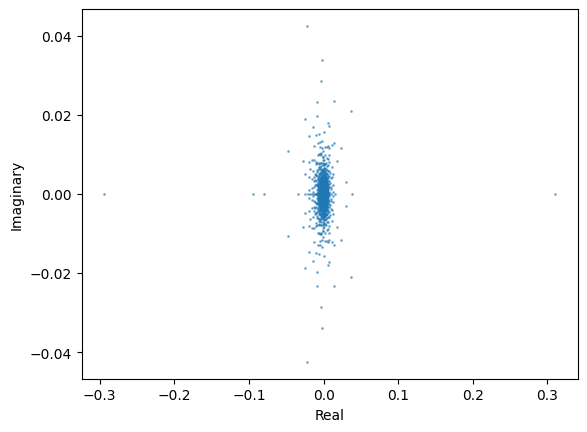

In [78]:
import matplotlib.pyplot as plt

plt.scatter(
    L0.real, L0.imag, label="Layer 0", alpha=0.5, s=1, c="C0"
)
plt.xlabel("Real")
plt.ylabel("Imaginary")

In [67]:
th.linalg.vecdot(Q0[rows], Q1[cols]).abs()

tensor([0.0665, 0.0595, 0.0672,  ..., 0.0771, 0.0578, 0.0383])

In [40]:
Q1[cols]

tensor([[-0.0117+0.0000j,  0.0031+0.0000j,  0.0236+0.0000j,  ...,
         -0.0101+0.0011j, -0.0101-0.0011j,  0.0086+0.0000j],
        [-0.0073+0.0000j, -0.0531+0.0000j,  0.0260+0.0000j,  ...,
         -0.0222-0.0115j, -0.0222+0.0115j,  0.0315+0.0000j],
        [ 0.0044+0.0000j, -0.0134+0.0000j, -0.0251+0.0000j,  ...,
          0.0234+0.0056j,  0.0234-0.0056j, -0.0237+0.0000j],
        ...,
        [ 0.0060+0.0000j, -0.0093+0.0000j,  0.0349+0.0000j,  ...,
          0.0127-0.0087j,  0.0127+0.0087j,  0.0239+0.0000j],
        [-0.0197+0.0000j, -0.0300+0.0000j,  0.0371+0.0000j,  ...,
         -0.0085+0.0069j, -0.0085-0.0069j, -0.0011+0.0000j],
        [ 0.0056+0.0000j, -0.0201+0.0000j, -0.0116+0.0000j,  ...,
         -0.0115+0.0176j, -0.0115-0.0176j,  0.0127+0.0000j]])